In [1]:
# Linear model inference (coeffs + intercepts)

import xarray as xr
import numpy as np
import os
from datetime import datetime

# Configuration
target_var = 'tasmax'            # 'pr' or 'tasmax'
domain = 'NZ'
root = '/r/scratch/users/mschillinger/data/cordexbench'
training_experiment = 'Emulator_hist_future'
period_training = '1961-1980_2080-2099'
folder = 'train'
alpha_val = 100.0

# Choose GCM by domain (match training)
if domain == 'ALPS':
    gcm_name = 'CNRM-CM5'
elif domain in ('NZ', 'SA'):
    gcm_name = 'ACCESS-CM2'
else:
    raise ValueError('Unknown domain')

DATA_PATH = f"{root}/{domain}/{domain}_domain"
predictors_path = f"{DATA_PATH}/{folder}/{training_experiment}/predictors/{gcm_name}_{period_training}.nc"
coef_path = f"{DATA_PATH}/{folder}/{training_experiment}/linear_models/ridge_{target_var}_{gcm_name}_{period_training}_alpha-{alpha_val}_coefs.nc"
inter_path = f"{DATA_PATH}/{folder}/{training_experiment}/linear_models/ridge_{target_var}_{gcm_name}_{period_training}_alpha-{alpha_val}_intercepts.nc"
scaler_path = f"{DATA_PATH}/{folder}/{training_experiment}/linear_models/ridge_{target_var}_{gcm_name}_{period_training}_alpha-{alpha_val}_perloc_scaler.nc"  # optional


In [3]:

# Load predictors and model artifacts
lr_ds = xr.open_dataset(predictors_path).astype('float32')
coefs = xr.open_dataarray(coef_path)
intercepts = xr.open_dataarray(inter_path)
# scaler_ds = xr.open_dataset(scaler_path)  # not required when using effective weights

# Align predictor order with saved coefficients
sorted_vars = lr_ds.data_vars
# remove time bounds
lr_ds = lr_ds[[v for v in sorted_vars if v != "time_bnds"]]
features_da = lr_ds.to_array()  # dims: variable, time?, lat, lon
features_da = features_da.transpose('time', 'lat', 'lon', 'variable')
features_da = features_da.sel(variable=coefs['variable'])
X = features_da.values.astype(np.float32)             # (time, lat, lon, variable)
coef_vals = coefs.values.astype(np.float32)           # (y, x, lat, lon, variable)

# Contract predictors with coefficients for all locations
preds = np.einsum('tijk,xyijk->txy', X, coef_vals).astype(np.float32)  # (time, y, x)
# Add effective intercepts per (y,x)
preds += intercepts.values[None, :, :].astype(np.float32)

In [5]:
preds.shape

(14600, 128, 128)

In [7]:
loaded = xr.open_dataset(f"/r/scratch/users/mschillinger/data/cordexbench/{domain}/{domain}_domain/train/{training_experiment}/linear_models/ridge_{target_var}_{gcm_name}_{period_training}_alpha-{alpha_val}_preds.nc")

In [12]:
loaded1000 = xr.open_dataset(f"/r/scratch/users/mschillinger/data/cordexbench/{domain}/{domain}_domain/train/{training_experiment}/linear_models/ridge_{target_var}_{gcm_name}_{period_training}_alpha-1000.0_preds.nc")

In [8]:
loaded

<xarray.Dataset> Size: 957MB
Dimensions:            (time: 14600, y: 128, x: 128)
Coordinates:
  * time               (time) datetime64[ns] 117kB 1961-01-01 ... 2099-12-31
  * y                  (y) float32 512B -47.56 -47.46 -47.35 ... -34.04 -33.93
  * x                  (x) float32 512B 166.0 166.1 166.3 ... 179.5 179.6 179.7
Data variables:
    tasmax_ridge_pred  (time, y, x) float32 957MB ...

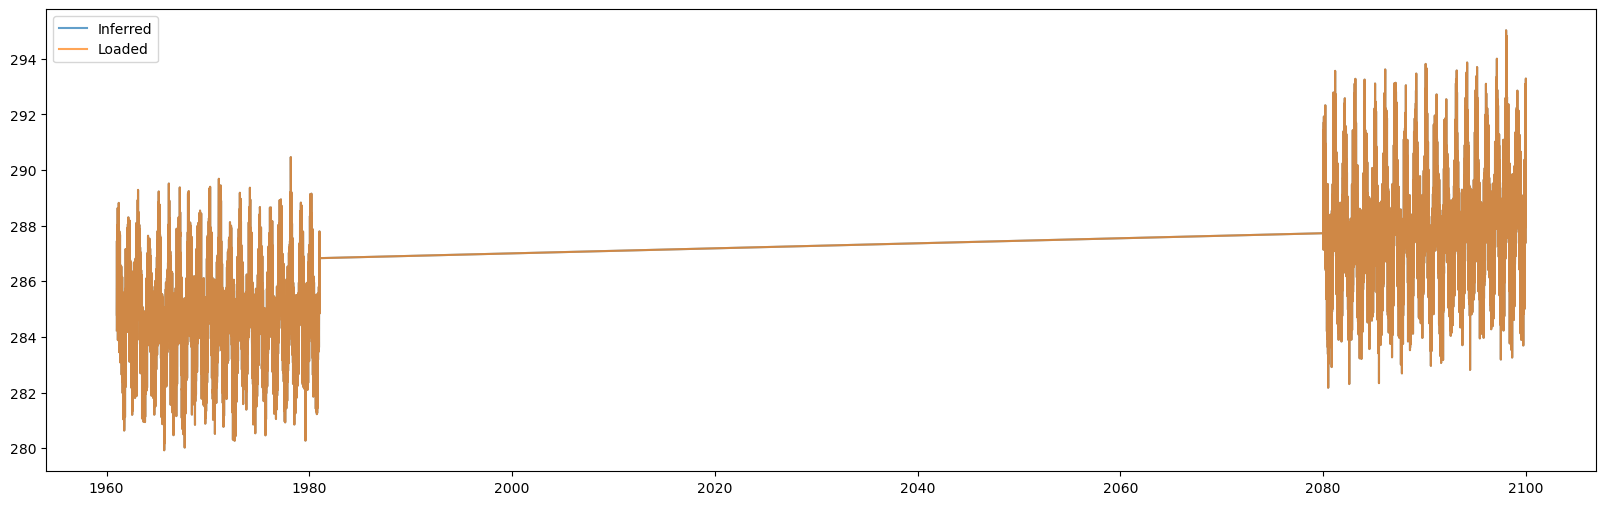

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(loaded['time'], preds[:, 1, 1], label='Inferred', alpha = 0.7)
plt.plot(loaded['time'], loaded['tasmax_ridge_pred'].isel(y=1, x=1), label='Loaded', alpha = 0.7)
plt.legend()

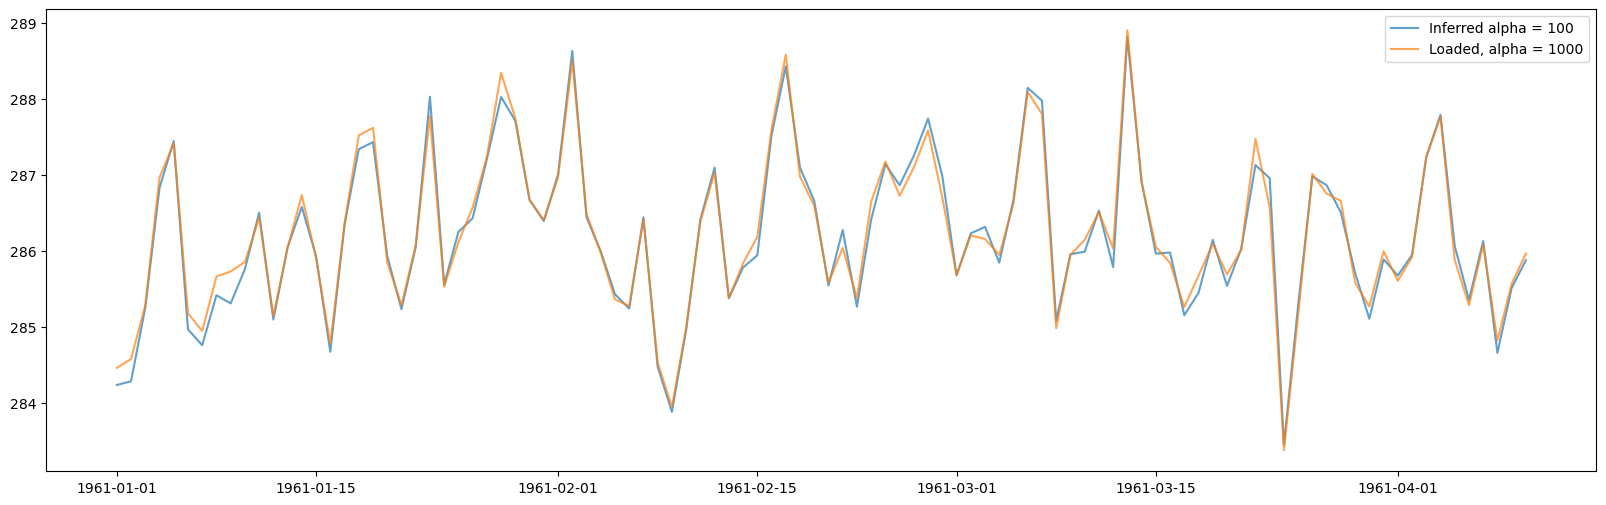

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(loaded['time'][:100], preds[:100, 1, 1], label='Inferred alpha = 100', alpha = 0.7)
plt.plot(loaded['time'][:100], loaded1000['tasmax_ridge_pred'].isel(y=1, x=1)[:100], label='Loaded, alpha = 1000', alpha = 0.7)
plt.legend()

In [14]:
loaded1000["tasmax_ridge_pred"].values - loaded["tasmax_ridge_pred"].values

array([[[ 0.22503662,  0.23028564,  0.24197388, ..., -0.04830933,
         -0.05740356, -0.06634521],
        [ 0.21746826,  0.22558594,  0.2394104 , ..., -0.06045532,
         -0.07226562, -0.08569336],
        [ 0.21044922,  0.21429443,  0.22283936, ..., -0.08502197,
         -0.09613037, -0.1078186 ],
        ...,
        [ 0.00128174, -0.00109863,  0.00067139, ..., -0.1890564 ,
         -0.18838501, -0.18667603],
        [ 0.01101685,  0.00613403,  0.00411987, ..., -0.17578125,
         -0.17382812, -0.17340088],
        [ 0.00869751,  0.00482178,  0.00128174, ..., -0.17687988,
         -0.18017578, -0.18563843]],

       [[ 0.3128357 ,  0.3050537 ,  0.30114746, ...,  0.05197144,
          0.05166626,  0.05270386],
        [ 0.29779053,  0.29309082,  0.2926941 , ...,  0.06210327,
          0.05969238,  0.05789185],
        [ 0.28823853,  0.2897339 ,  0.2916565 , ...,  0.07064819,
          0.06530762,  0.059021  ],
        ...,
        [ 0.02700806,  0.02786255,  0.0328064 , ...,  

In [20]:
test_params={"period": "historical",
            "gcm": "ACCESS-CM2",
            "framework": "perfect"}

if test_params["period"] == "historical":
    period_inference = "1981-2000"
elif test_params["period"] == "mid_century":
    period_inference = "2041-2060"
elif test_params["period"] == "end_century":
    period_inference = "2080-2099"  

lr_path = f'{DATA_PATH}/test/{test_params["period"]}/predictors/{test_params["framework"]}/{test_params["gcm"]}_{period_inference}.nc'

# Load predictors and model artifacts
lr_ds = xr.open_dataset(lr_path).astype('float32')
coefs = xr.open_dataarray(coef_path)
intercepts = xr.open_dataarray(inter_path)
# scaler_ds = xr.open_dataset(scaler_path)  # not required when using effective weights

# Align predictor order with saved coefficients
sorted_vars = lr_ds.data_vars
# remove time bounds
lr_ds = lr_ds[[v for v in sorted_vars if v != "time_bnds"]]
features_da = lr_ds.to_array()  # dims: variable, time?, lat, lon
features_da = features_da.transpose('time', 'lat', 'lon', 'variable')
features_da = features_da.sel(variable=coefs['variable'])
X = features_da.values.astype(np.float32)             # (time, lat, lon, variable)
coef_vals = coefs.values.astype(np.float32)           # (y, x, lat, lon, variable)

# Contract predictors with coefficients for all locations
preds = np.einsum('tijk,xyijk->txy', X, coef_vals).astype(np.float32)  # (time, y, x)
# Add effective intercepts per (y,x)
preds += intercepts.values[None, :, :].astype(np.float32)

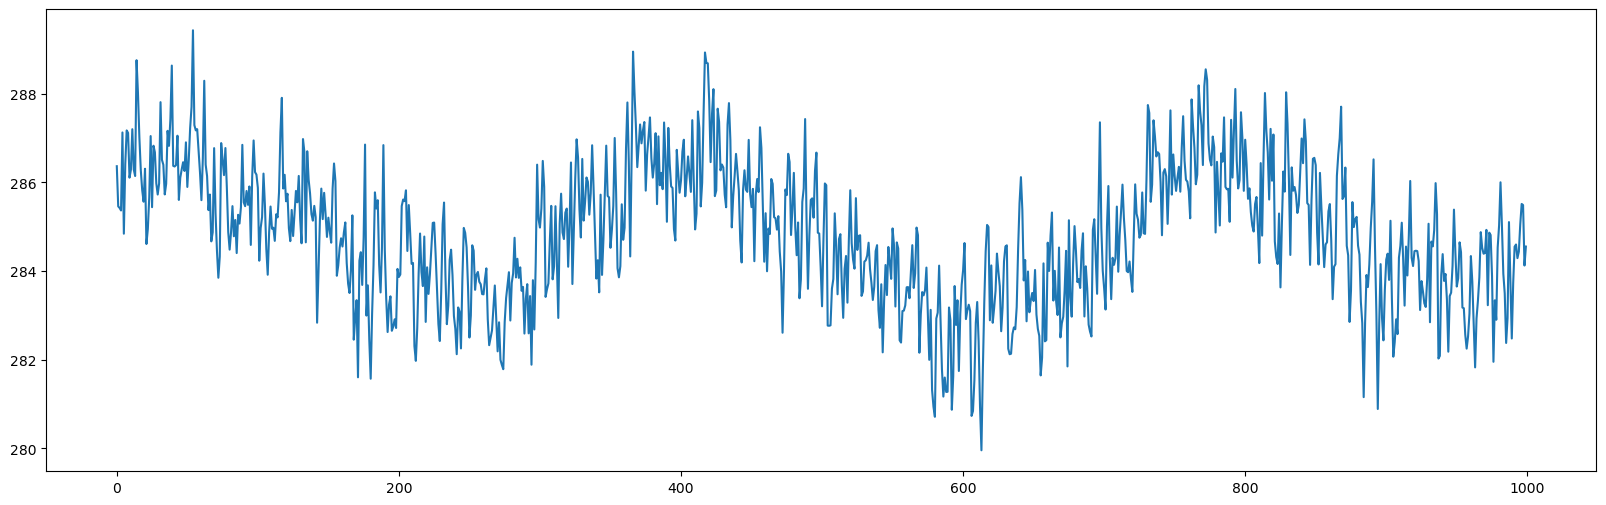

In [22]:
plt.figure(figsize=(20, 6) )
plt.plot(preds[:1000, 1, 1])

In [33]:
alpha_val = 1000.0
DATA_PATH = f"{root}/{domain}/{domain}_domain"
predictors_path = f"{DATA_PATH}/{folder}/{training_experiment}/predictors/{gcm_name}_{period_training}.nc"
coef_path = f"{DATA_PATH}/{folder}/{training_experiment}/linear_models/ridge_{target_var}_{gcm_name}_{period_training}_alpha-{alpha_val}_coefs.nc"
inter_path = f"{DATA_PATH}/{folder}/{training_experiment}/linear_models/ridge_{target_var}_{gcm_name}_{period_training}_alpha-{alpha_val}_intercepts.nc"
scaler_path = f"{DATA_PATH}/{folder}/{training_experiment}/linear_models/ridge_{target_var}_{gcm_name}_{period_training}_alpha-{alpha_val}_perloc_scaler.nc"  # optional

In [35]:
test_params={"period": "historical",
            "gcm": "ACCESS-CM2",
            "framework": "perfect"}

if test_params["period"] == "historical":
    period_inference = "1981-2000"
elif test_params["period"] == "mid_century":
    period_inference = "2041-2060"
elif test_params["period"] == "end_century":
    period_inference = "2080-2099"  

lr_path = f'{DATA_PATH}/test/{test_params["period"]}/predictors/{test_params["framework"]}/{test_params["gcm"]}_{period_inference}.nc'

# Load predictors and model artifacts
lr_ds = xr.open_dataset(lr_path).astype('float32')
coefs = xr.open_dataarray(coef_path)
intercepts = xr.open_dataarray(inter_path)
# scaler_ds = xr.open_dataset(scaler_path)  # not required when using effective weights

# Align predictor order with saved coefficients
sorted_vars = lr_ds.data_vars
# remove time bounds
lr_ds = lr_ds[[v for v in sorted_vars if v != "time_bnds"]]
features_da = lr_ds.to_array()  # dims: variable, time?, lat, lon
features_da = features_da.transpose('time', 'lat', 'lon', 'variable')
features_da = features_da.sel(variable=coefs['variable'])
X = features_da.values.astype(np.float32)             # (time, lat, lon, variable)
coef_vals = coefs.values.astype(np.float32)           # (y, x, lat, lon, variable)

# Contract predictors with coefficients for all locations
preds1000 = np.einsum('tijk,xyijk->txy', X, coef_vals).astype(np.float32)  # (time, y, x)
# Add effective intercepts per (y,x)
preds1000 += intercepts.values[None, :, :].astype(np.float32)

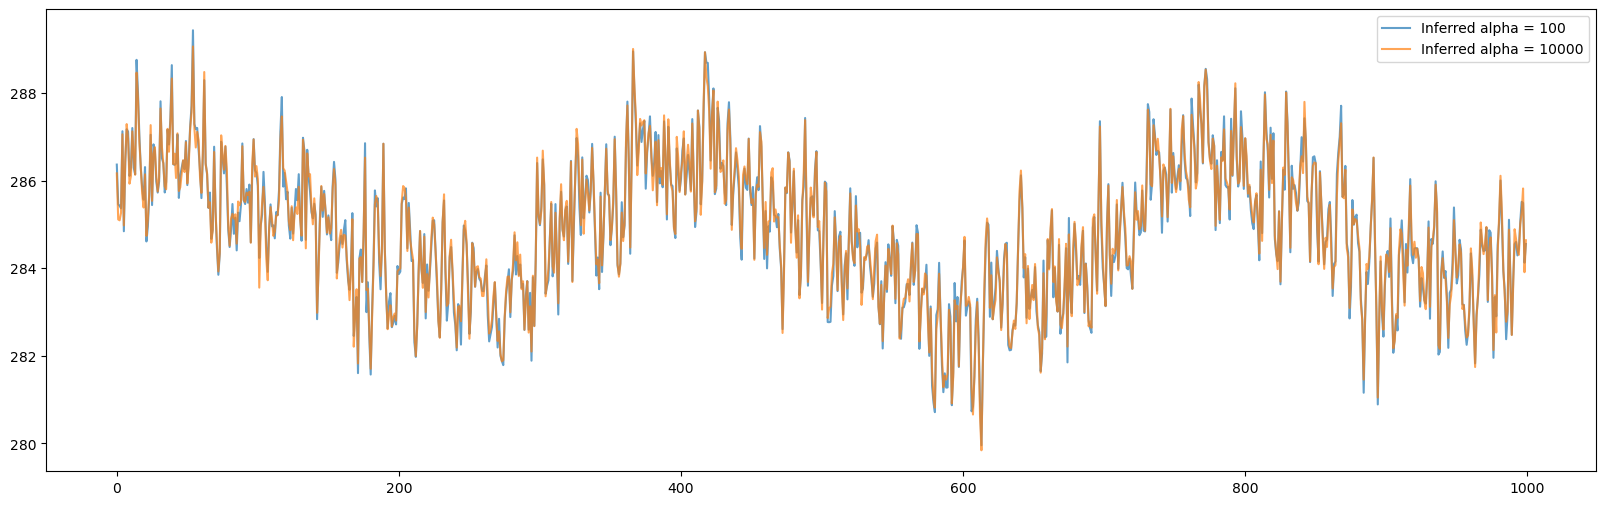

In [36]:
plt.figure(figsize=(20, 6) )
plt.plot(preds[:1000, 1, 1], label='Inferred alpha = 100', alpha = 0.7)
plt.plot(preds1000[:1000, 1, 1], label='Inferred alpha = 10000', alpha = 0.7)
plt.legend();

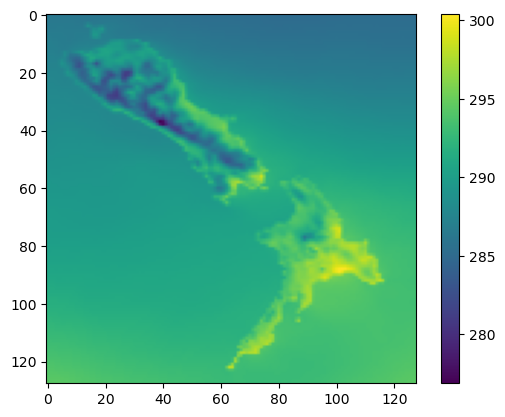

In [39]:
plt.imshow(preds[10])
plt.colorbar();

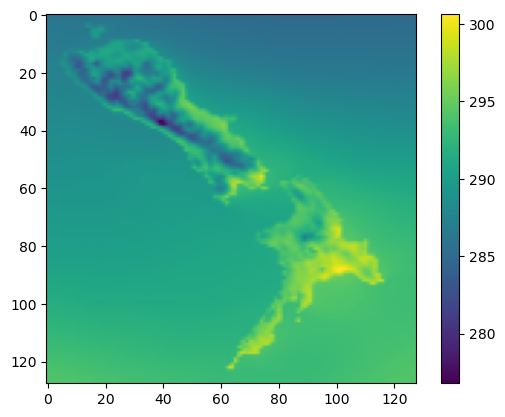

In [40]:
plt.imshow(preds1000[10])
plt.colorbar();